<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN (Conditional GAN)

- cGAN : https://arxiv.org/pdf/1411.1784 (discrete conditions)
- CcGAN : https://openreview.net/pdf?id=PrzjugOsDeE (continuous, scalar conditions)


## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 17.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 29.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 64.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31

## 2. Import python libraries and define util functions

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

In [3]:
set_seed(0)

## 3. Check dataset

In [4]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [5]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X,Y = [],[]  # initialize empty lists for storing images and labels

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1
        Y.append(float(file[:-4]))  # extract label from filename

    X = np.array(X)  # convert the list of images to a numpy array
    Y = np.array(Y)  # convert the list of labels to a numpy array

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    # normalize Y to a specific range, e.g., [-1, 1]
    y_min, y_max = y_train.min(), y_train.max()
    y_train_norm = 2 * (y_train - y_min) / (y_max - y_min) - 1  # Normalize to [-1, 1]
    y_test_norm = 2 * (y_test - y_min) / (y_max - y_min) - 1    # Use the same scale as training

    return X_train, X_test, y_train_norm, y_test_norm

X_train, X_test, y_train, y_test = get_data()  # load data set

print("X_train.shape =", X_train.shape)  # Expected: (N_train, 1, 56, 56)
print("y_train.shape =", y_train.shape)  # Expected: (N_train,)
print("X_test.shape =", X_test.shape)    # Expected: (N_test, 1, 56, 56)
print("y_test.shape =", y_test.shape)    # Expected: (N_test,)

X_train.shape = (1600, 1, 56, 56)
y_train.shape = (1600,)
X_test.shape = (400, 1, 56, 56)
y_test.shape = (400,)


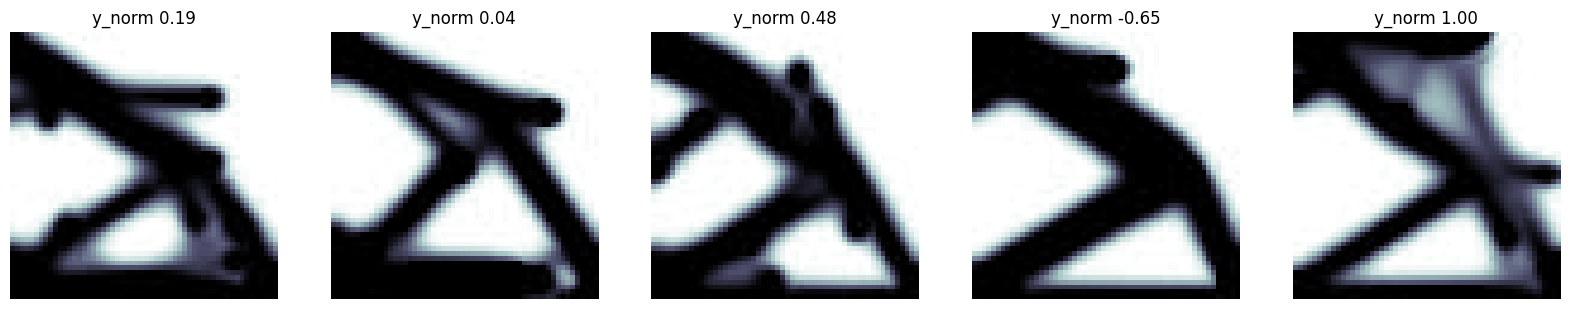

In [6]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
    ax.set_title(f"y_norm {y_train[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Set to model architecture

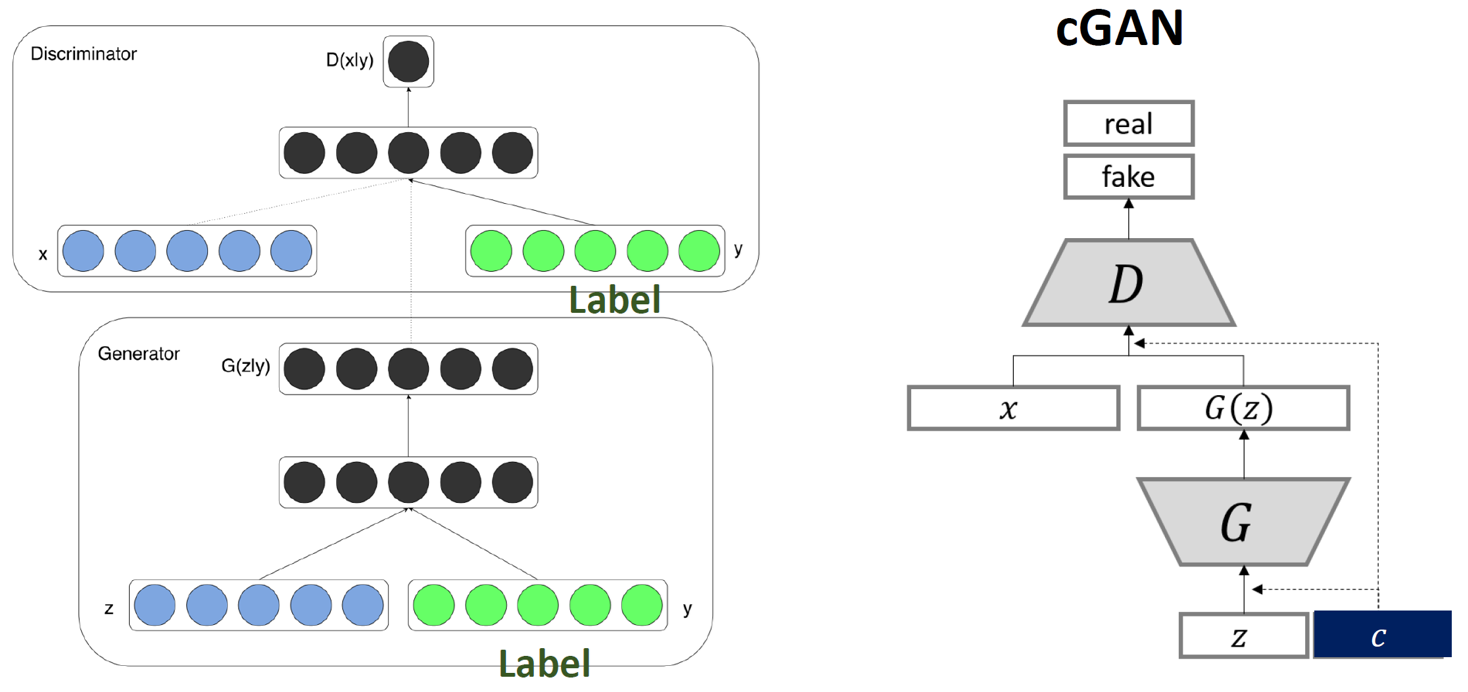

https://arxiv.org/pdf/1411.1784

https://github.com/hwalsuklee/tensorflow-generative-model-collections

In [7]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self, noise_size, label_size, hidden_size1=256, hidden_size2=512, hidden_size3=1024, img_size=56*56):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_size + label_size, hidden_size1),
            nn.ReLU(True),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(True),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(True),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )

    def forward(self, noise, labels):

        gen_input = torch.cat((noise, labels), dim=1)  # concatenate noise and labels
        img = self.model(gen_input)

        return img

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self, label_size, hidden_size1=256, hidden_size2=512, hidden_size3=1024, img_size=56*56):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size + label_size, hidden_size3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()  # output probability between [0, 1]
        )

    def forward(self, img, labels):

        dis_input = torch.cat((img, labels), dim=1)  # concatenate image and labels
        validity = self.model(dis_input)

        return validity

## 6. Set model hyperparameters

In [8]:
# model architecture parameters
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
noise_size = 100
label_size = 1  # since Y is a single continuous value

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 200

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

In [9]:
# define networks and set to device (GPU)
generator = Generator(noise_size=noise_size, label_size=label_size).to(device)
discriminator = Discriminator(label_size=label_size).to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
train_labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (N, 1)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [10]:
# fixed noise and labels for visualization
fixed_labels = torch.linspace(-1, 1, steps=10).unsqueeze(1).to(device)  # example fixed labels in [-1, 1]
fixed_noise = torch.randn(10, noise_size).to(device)

# create a directory to save generated images
os.makedirs("./cGAN_samples/", exist_ok=True)

Epoch [1/200]  D Loss: 0.1982  G Loss: 1.4418


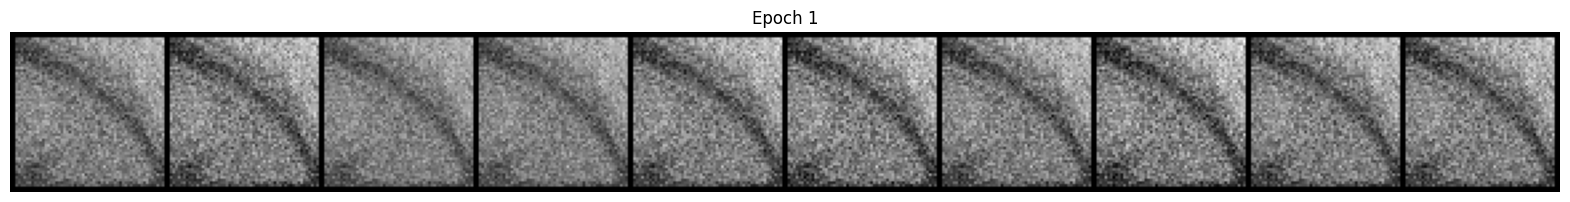

Epoch [2/200]  D Loss: 0.4152  G Loss: 1.0075
Epoch [3/200]  D Loss: 0.2947  G Loss: 2.1320
Epoch [4/200]  D Loss: 0.6840  G Loss: 0.7466
Epoch [5/200]  D Loss: 1.2670  G Loss: 0.5148
Epoch [6/200]  D Loss: 0.9710  G Loss: 1.9075
Epoch [7/200]  D Loss: 0.0518  G Loss: 3.6336
Epoch [8/200]  D Loss: 0.1734  G Loss: 4.8511
Epoch [9/200]  D Loss: 0.2834  G Loss: 2.7717
Epoch [10/200]  D Loss: 0.0763  G Loss: 6.3464
Epoch [11/200]  D Loss: 0.2500  G Loss: 5.7368
Epoch [12/200]  D Loss: 0.1051  G Loss: 7.4865
Epoch [13/200]  D Loss: 0.0617  G Loss: 3.4764
Epoch [14/200]  D Loss: 0.0073  G Loss: 5.7123
Epoch [15/200]  D Loss: 0.1306  G Loss: 3.8554
Epoch [16/200]  D Loss: 0.0529  G Loss: 5.8540
Epoch [17/200]  D Loss: 0.4546  G Loss: 1.9603
Epoch [18/200]  D Loss: 0.1070  G Loss: 4.1702
Epoch [19/200]  D Loss: 0.3795  G Loss: 2.4754
Epoch [20/200]  D Loss: 0.0837  G Loss: 2.9855


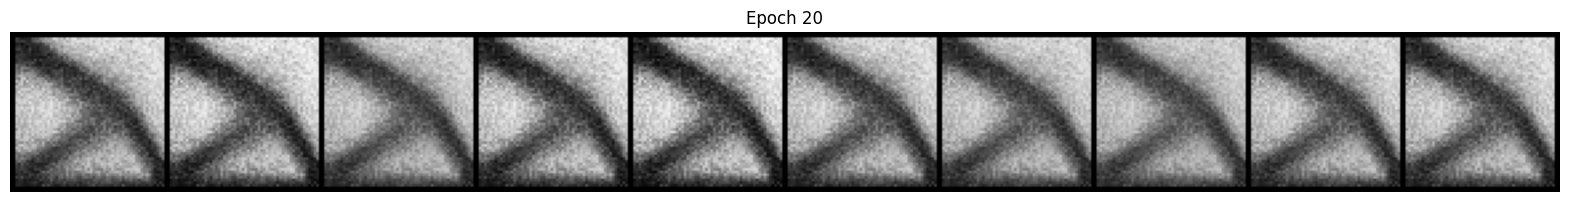

Epoch [21/200]  D Loss: 0.2046  G Loss: 4.4312
Epoch [22/200]  D Loss: 0.0463  G Loss: 4.2411
Epoch [23/200]  D Loss: 0.0815  G Loss: 4.7966
Epoch [24/200]  D Loss: 0.0217  G Loss: 5.6717
Epoch [25/200]  D Loss: 0.7323  G Loss: 1.5148
Epoch [26/200]  D Loss: 0.3250  G Loss: 3.0762
Epoch [27/200]  D Loss: 0.0722  G Loss: 4.2305
Epoch [28/200]  D Loss: 0.0899  G Loss: 5.1823
Epoch [29/200]  D Loss: 0.1525  G Loss: 3.9998
Epoch [30/200]  D Loss: 0.5507  G Loss: 2.5887
Epoch [31/200]  D Loss: 0.2483  G Loss: 1.8630
Epoch [32/200]  D Loss: 0.2871  G Loss: 2.0195
Epoch [33/200]  D Loss: 0.2111  G Loss: 5.2747
Epoch [34/200]  D Loss: 0.1215  G Loss: 3.4755
Epoch [35/200]  D Loss: 0.1437  G Loss: 3.6474
Epoch [36/200]  D Loss: 0.2525  G Loss: 4.9173
Epoch [37/200]  D Loss: 0.1144  G Loss: 2.7086
Epoch [38/200]  D Loss: 0.2333  G Loss: 5.0467
Epoch [39/200]  D Loss: 0.1355  G Loss: 5.4669
Epoch [40/200]  D Loss: 0.0691  G Loss: 3.6944


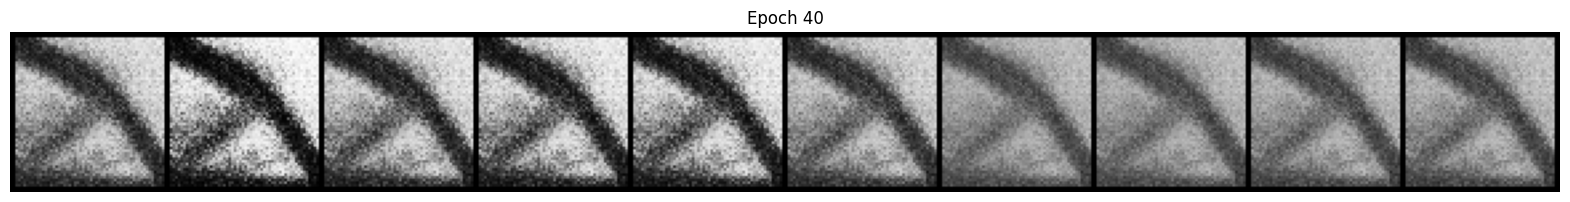

Epoch [41/200]  D Loss: 0.1324  G Loss: 2.5286
Epoch [42/200]  D Loss: 0.0682  G Loss: 4.3634
Epoch [43/200]  D Loss: 0.1452  G Loss: 2.4340
Epoch [44/200]  D Loss: 0.1375  G Loss: 3.2990
Epoch [45/200]  D Loss: 0.1585  G Loss: 2.4381
Epoch [46/200]  D Loss: 0.1051  G Loss: 2.1762
Epoch [47/200]  D Loss: 0.0926  G Loss: 2.1727
Epoch [48/200]  D Loss: 0.2187  G Loss: 3.4331
Epoch [49/200]  D Loss: 0.3762  G Loss: 5.4181
Epoch [50/200]  D Loss: 0.1414  G Loss: 4.1523
Epoch [51/200]  D Loss: 0.0889  G Loss: 3.7086
Epoch [52/200]  D Loss: 0.0841  G Loss: 2.5361
Epoch [53/200]  D Loss: 0.0418  G Loss: 3.1438
Epoch [54/200]  D Loss: 0.5191  G Loss: 6.1386
Epoch [55/200]  D Loss: 0.0868  G Loss: 2.3488
Epoch [56/200]  D Loss: 0.0750  G Loss: 2.6663
Epoch [57/200]  D Loss: 0.0632  G Loss: 2.4825
Epoch [58/200]  D Loss: 0.0437  G Loss: 4.6681
Epoch [59/200]  D Loss: 0.1590  G Loss: 2.5312
Epoch [60/200]  D Loss: 0.0544  G Loss: 3.1690


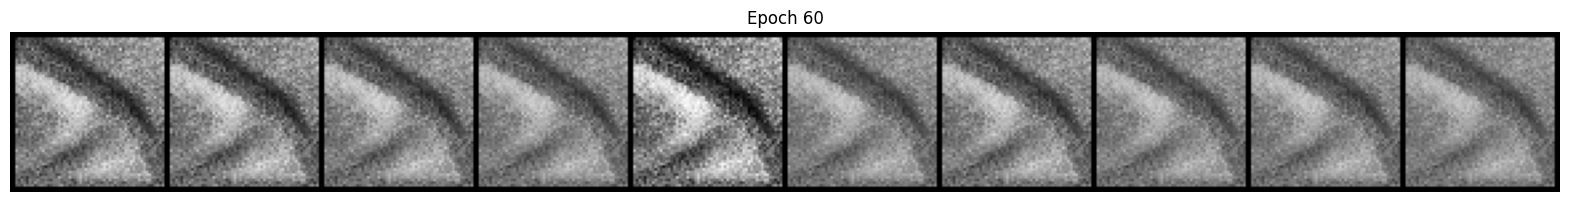

Epoch [61/200]  D Loss: 0.2057  G Loss: 2.0499
Epoch [62/200]  D Loss: 0.0596  G Loss: 2.8451
Epoch [63/200]  D Loss: 0.1026  G Loss: 2.1426
Epoch [64/200]  D Loss: 0.1911  G Loss: 2.6731
Epoch [65/200]  D Loss: 0.0182  G Loss: 5.4602
Epoch [66/200]  D Loss: 0.0235  G Loss: 4.1559
Epoch [67/200]  D Loss: 0.2948  G Loss: 2.0954
Epoch [68/200]  D Loss: 0.2085  G Loss: 2.5752
Epoch [69/200]  D Loss: 0.1359  G Loss: 2.0790
Epoch [70/200]  D Loss: 0.2623  G Loss: 2.4538
Epoch [71/200]  D Loss: 0.0227  G Loss: 5.8203
Epoch [72/200]  D Loss: 0.1918  G Loss: 1.7728
Epoch [73/200]  D Loss: 0.0670  G Loss: 2.8547
Epoch [74/200]  D Loss: 0.0218  G Loss: 4.3159
Epoch [75/200]  D Loss: 0.2602  G Loss: 2.0021
Epoch [76/200]  D Loss: 0.2087  G Loss: 4.7533
Epoch [77/200]  D Loss: 0.1337  G Loss: 6.6227
Epoch [78/200]  D Loss: 0.1713  G Loss: 5.1947
Epoch [79/200]  D Loss: 0.3284  G Loss: 4.8572
Epoch [80/200]  D Loss: 0.1437  G Loss: 2.1139


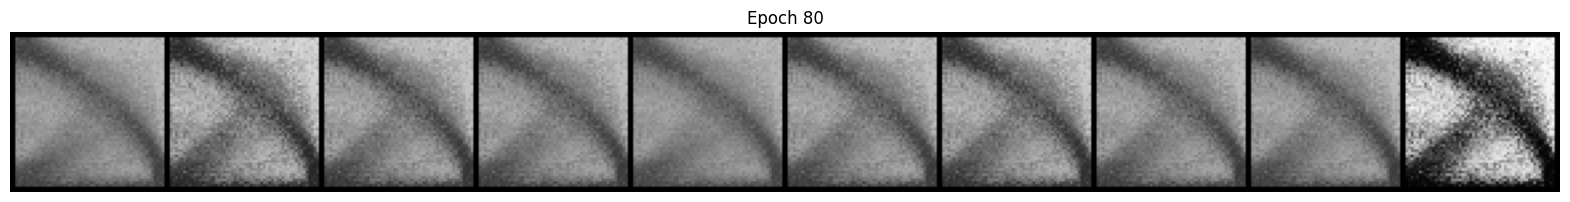

Epoch [81/200]  D Loss: 0.0934  G Loss: 2.7657
Epoch [82/200]  D Loss: 0.2532  G Loss: 4.9799
Epoch [83/200]  D Loss: 0.2967  G Loss: 4.0643
Epoch [84/200]  D Loss: 0.0538  G Loss: 3.8347
Epoch [85/200]  D Loss: 0.2778  G Loss: 2.5534
Epoch [86/200]  D Loss: 0.1218  G Loss: 3.0878
Epoch [87/200]  D Loss: 0.0257  G Loss: 4.6737
Epoch [88/200]  D Loss: 0.0530  G Loss: 3.4911
Epoch [89/200]  D Loss: 0.3350  G Loss: 3.0959
Epoch [90/200]  D Loss: 0.1602  G Loss: 2.5451
Epoch [91/200]  D Loss: 0.2589  G Loss: 4.1700
Epoch [92/200]  D Loss: 0.2601  G Loss: 2.5894
Epoch [93/200]  D Loss: 0.1179  G Loss: 3.7915
Epoch [94/200]  D Loss: 0.3775  G Loss: 5.5319
Epoch [95/200]  D Loss: 0.1551  G Loss: 2.5346
Epoch [96/200]  D Loss: 0.0749  G Loss: 3.5736
Epoch [97/200]  D Loss: 0.0738  G Loss: 2.6165
Epoch [98/200]  D Loss: 0.2295  G Loss: 2.6469
Epoch [99/200]  D Loss: 0.4055  G Loss: 5.4746
Epoch [100/200]  D Loss: 0.2264  G Loss: 3.2999


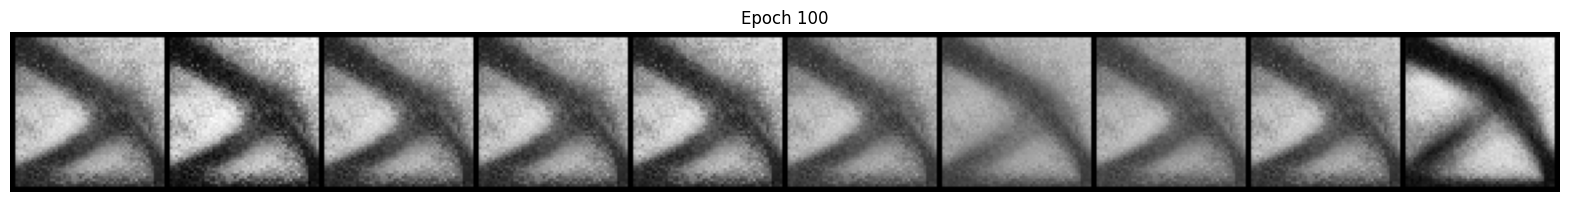

Epoch [101/200]  D Loss: 0.1327  G Loss: 3.1398
Epoch [102/200]  D Loss: 0.0754  G Loss: 3.5931
Epoch [103/200]  D Loss: 0.0289  G Loss: 4.0212
Epoch [104/200]  D Loss: 0.1227  G Loss: 2.6655
Epoch [105/200]  D Loss: 0.2917  G Loss: 4.1995
Epoch [106/200]  D Loss: 0.3584  G Loss: 3.4723
Epoch [107/200]  D Loss: 0.1399  G Loss: 3.0353
Epoch [108/200]  D Loss: 0.2796  G Loss: 5.3132
Epoch [109/200]  D Loss: 0.0790  G Loss: 3.9846
Epoch [110/200]  D Loss: 0.1298  G Loss: 3.5735
Epoch [111/200]  D Loss: 0.1814  G Loss: 4.6710
Epoch [112/200]  D Loss: 0.0340  G Loss: 3.6491
Epoch [113/200]  D Loss: 0.2149  G Loss: 4.3439
Epoch [114/200]  D Loss: 0.3456  G Loss: 3.8859
Epoch [115/200]  D Loss: 0.2109  G Loss: 3.0432
Epoch [116/200]  D Loss: 0.2217  G Loss: 2.8993
Epoch [117/200]  D Loss: 0.0957  G Loss: 3.3108
Epoch [118/200]  D Loss: 0.1134  G Loss: 2.7899
Epoch [119/200]  D Loss: 0.2403  G Loss: 3.5978
Epoch [120/200]  D Loss: 0.2367  G Loss: 2.5967


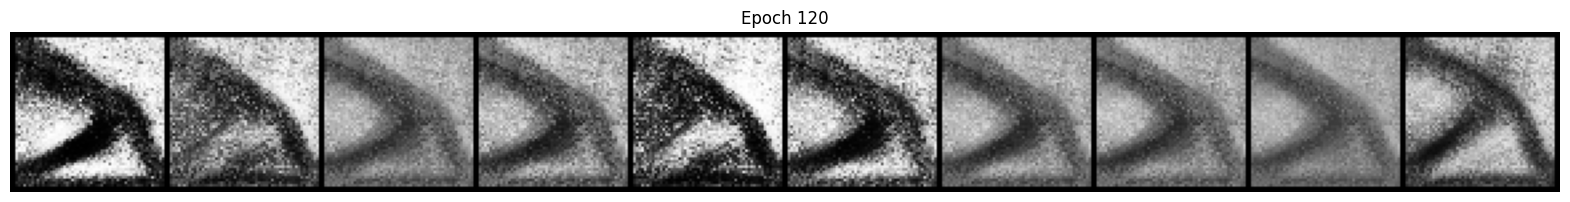

Epoch [121/200]  D Loss: 0.3507  G Loss: 2.4195
Epoch [122/200]  D Loss: 0.2441  G Loss: 3.2620
Epoch [123/200]  D Loss: 0.1444  G Loss: 3.2128
Epoch [124/200]  D Loss: 0.0818  G Loss: 3.5344
Epoch [125/200]  D Loss: 0.2511  G Loss: 3.8439
Epoch [126/200]  D Loss: 0.0727  G Loss: 4.4621
Epoch [127/200]  D Loss: 0.1779  G Loss: 3.8887
Epoch [128/200]  D Loss: 0.2572  G Loss: 2.7160
Epoch [129/200]  D Loss: 0.1466  G Loss: 4.5531
Epoch [130/200]  D Loss: 0.1475  G Loss: 3.7629
Epoch [131/200]  D Loss: 0.2309  G Loss: 3.9543
Epoch [132/200]  D Loss: 0.1654  G Loss: 3.8239
Epoch [133/200]  D Loss: 0.1545  G Loss: 4.1257
Epoch [134/200]  D Loss: 0.1523  G Loss: 3.9299
Epoch [135/200]  D Loss: 0.1613  G Loss: 4.4555
Epoch [136/200]  D Loss: 0.1276  G Loss: 3.1030
Epoch [137/200]  D Loss: 0.2288  G Loss: 3.3123
Epoch [138/200]  D Loss: 0.1056  G Loss: 4.7797
Epoch [139/200]  D Loss: 0.1766  G Loss: 2.8796
Epoch [140/200]  D Loss: 0.3303  G Loss: 2.8368


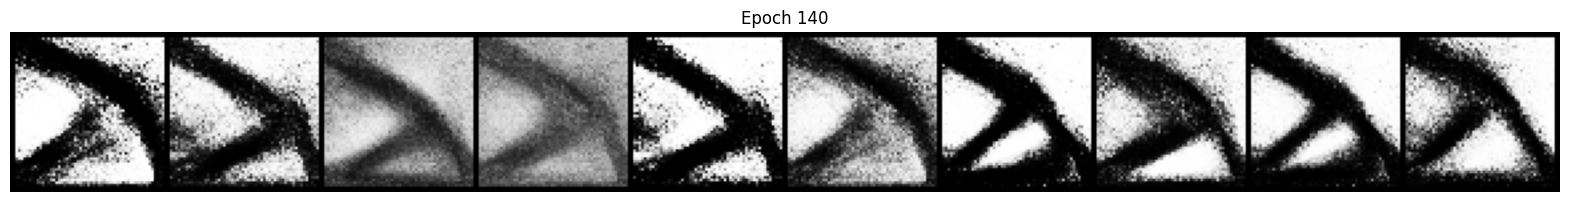

Epoch [141/200]  D Loss: 0.1742  G Loss: 2.7207
Epoch [142/200]  D Loss: 0.1423  G Loss: 3.2832
Epoch [143/200]  D Loss: 0.2737  G Loss: 2.6184
Epoch [144/200]  D Loss: 0.1387  G Loss: 2.8710
Epoch [145/200]  D Loss: 0.2562  G Loss: 3.4647
Epoch [146/200]  D Loss: 0.3098  G Loss: 3.9852
Epoch [147/200]  D Loss: 0.1300  G Loss: 4.9427
Epoch [148/200]  D Loss: 0.2289  G Loss: 3.4335
Epoch [149/200]  D Loss: 0.1989  G Loss: 4.3463
Epoch [150/200]  D Loss: 0.0994  G Loss: 3.3603
Epoch [151/200]  D Loss: 0.2169  G Loss: 3.5165
Epoch [152/200]  D Loss: 0.1437  G Loss: 3.4039
Epoch [153/200]  D Loss: 0.2379  G Loss: 2.5266
Epoch [154/200]  D Loss: 0.1777  G Loss: 2.7684
Epoch [155/200]  D Loss: 0.1227  G Loss: 5.6971
Epoch [156/200]  D Loss: 0.1472  G Loss: 3.4346
Epoch [157/200]  D Loss: 0.1522  G Loss: 4.6520
Epoch [158/200]  D Loss: 0.3238  G Loss: 3.5783
Epoch [159/200]  D Loss: 0.2417  G Loss: 2.9046
Epoch [160/200]  D Loss: 0.3587  G Loss: 3.1127


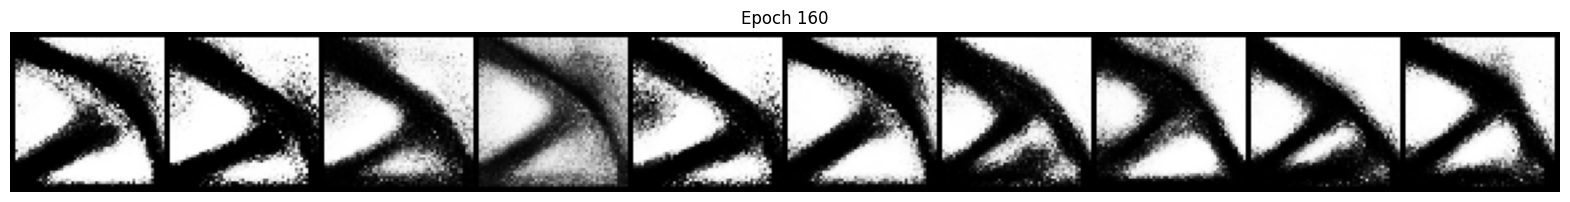

Epoch [161/200]  D Loss: 0.2560  G Loss: 2.7364
Epoch [162/200]  D Loss: 0.2271  G Loss: 2.8864
Epoch [163/200]  D Loss: 0.1452  G Loss: 3.8937
Epoch [164/200]  D Loss: 0.1060  G Loss: 3.3426
Epoch [165/200]  D Loss: 0.1710  G Loss: 2.8154
Epoch [166/200]  D Loss: 0.3281  G Loss: 2.6652
Epoch [167/200]  D Loss: 0.3941  G Loss: 3.5125
Epoch [168/200]  D Loss: 0.1314  G Loss: 3.7196
Epoch [169/200]  D Loss: 0.3893  G Loss: 3.1060
Epoch [170/200]  D Loss: 0.2964  G Loss: 2.7804
Epoch [171/200]  D Loss: 0.3234  G Loss: 3.0398
Epoch [172/200]  D Loss: 0.2471  G Loss: 3.3170
Epoch [173/200]  D Loss: 0.3236  G Loss: 2.5703
Epoch [174/200]  D Loss: 0.2164  G Loss: 3.2068
Epoch [175/200]  D Loss: 0.2181  G Loss: 2.9000
Epoch [176/200]  D Loss: 0.2539  G Loss: 3.1453
Epoch [177/200]  D Loss: 0.3671  G Loss: 2.2609
Epoch [178/200]  D Loss: 0.1934  G Loss: 4.2536
Epoch [179/200]  D Loss: 0.2319  G Loss: 3.7133
Epoch [180/200]  D Loss: 0.2369  G Loss: 4.6628


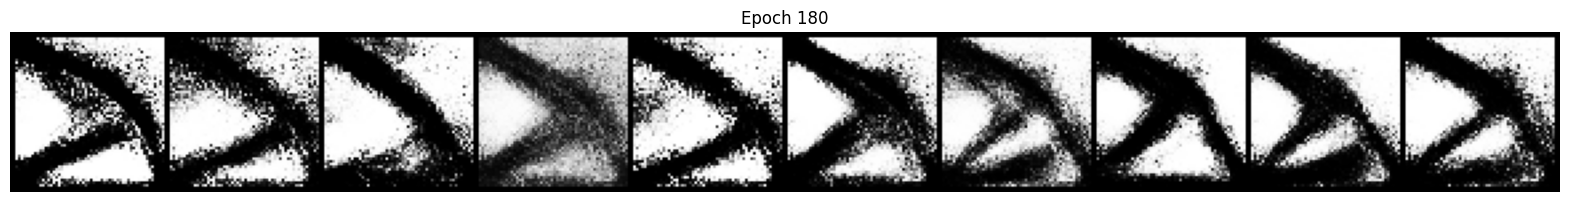

Epoch [181/200]  D Loss: 0.2755  G Loss: 3.0328
Epoch [182/200]  D Loss: 0.1430  G Loss: 4.2160
Epoch [183/200]  D Loss: 0.2496  G Loss: 2.9007
Epoch [184/200]  D Loss: 0.3032  G Loss: 3.0985
Epoch [185/200]  D Loss: 0.4438  G Loss: 2.7734
Epoch [186/200]  D Loss: 0.2948  G Loss: 1.8292
Epoch [187/200]  D Loss: 0.1703  G Loss: 2.9002
Epoch [188/200]  D Loss: 0.1827  G Loss: 3.6434
Epoch [189/200]  D Loss: 0.2110  G Loss: 3.8879
Epoch [190/200]  D Loss: 0.1745  G Loss: 3.4302
Epoch [191/200]  D Loss: 0.1420  G Loss: 3.3241
Epoch [192/200]  D Loss: 0.2048  G Loss: 2.5866
Epoch [193/200]  D Loss: 0.2608  G Loss: 2.5890
Epoch [194/200]  D Loss: 0.1898  G Loss: 2.7800
Epoch [195/200]  D Loss: 0.2018  G Loss: 2.6833
Epoch [196/200]  D Loss: 0.3729  G Loss: 3.8749
Epoch [197/200]  D Loss: 0.1478  G Loss: 3.1431
Epoch [198/200]  D Loss: 0.1401  G Loss: 3.3782
Epoch [199/200]  D Loss: 0.3391  G Loss: 2.4249
Epoch [200/200]  D Loss: 0.2342  G Loss: 2.9201


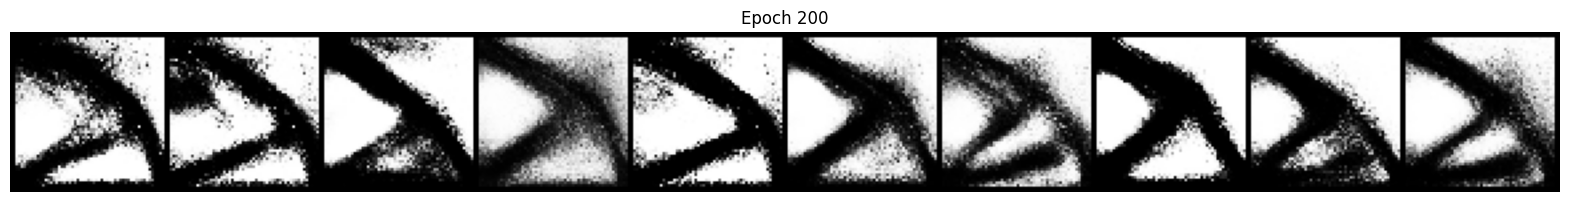

In [11]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real = torch.ones(batch_size_current, 1).to(device)
        fake = torch.zeros(batch_size_current, 1).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_imgs = imgs.view(batch_size_current, -1).to(device)  # flatten image to (batch_size, 56*56)
        labels = labels.to(device)

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        discriminator.zero_grad()

        # discriminator loss on real images
        output_real = discriminator(real_imgs, labels)
        d_loss_real = criterion(output_real, real)

        # generate fake images and get discriminator output
        z = torch.randn(batch_size_current, noise_size).to(device)
        fake_imgs = generator(z, labels)
        output_fake = discriminator(fake_imgs.detach(), labels)
        d_loss_fake = criterion(output_fake, fake)

        # total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        generator.zero_grad()

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        output = discriminator(fake_imgs, labels)
        g_loss = criterion(output, real)  # generator wants discriminator to label fake as real

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

    # print losses at the end of each epoch
    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

    # save and visualize generated images at specific intervals
    if epoch % 20 == 0 or epoch == 1:
        with torch.no_grad():
            # generate a set of images with a range of Y values
            fake_images = generator(fixed_noise, fixed_labels).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # save images as a grid using save_image
        save_image(fake_images, f"./cGAN_samples/cGAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./cGAN_samples/cGAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # optionally, save model checkpoints
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./cGAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./cGAN_samples/discriminator_epoch_{epoch}.pth")

## 8. Load & Evaluate model

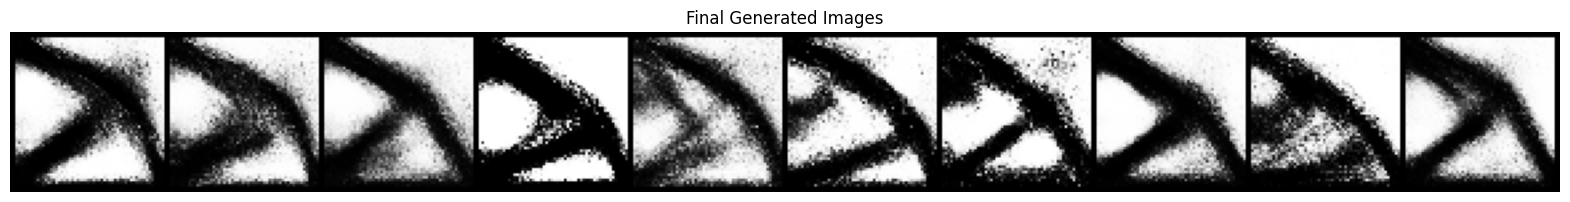

In [12]:
# final image generation and visualization
with torch.no_grad():
    final_noise = torch.randn(10, noise_size).to(device)
    final_labels = torch.linspace(-1, 1, steps=10).unsqueeze(1).to(device)
    final_fake_images = generator(final_noise, final_labels).cpu()
    final_fake_images = final_fake_images.view(-1, 1, 56, 56)
    save_image(final_fake_images, f"./cGAN_samples/cGAN_final.png", nrow=10, normalize=True)

# display the final generated images
plt.figure(figsize=(20, 4))
img = plt.imread("./cGAN_samples/cGAN_final.png")
plt.imshow(img)
plt.title("Final Generated Images")
plt.axis('off')
plt.show()